In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math

In [2]:
# Constants
N = 100       # Number of monomers
kb = 1.38e-23 # Boltzmann constant
T = 300      # Temperature in Kelvin
F = 10   # Force value
b = 3
num_steps = 1000 # Number of Metropolis steps

# Boltzmann constant in J/K
kb_J_per_K = 1.38e-23

# Convert kb to Hartrees/K (1 Hartree = 4.36 x 10^-18 J)
kb_Hartrees_per_K = kb_J_per_K / (4.36e-18)

In [3]:
#Reading the generated .xyz file for corresponding parameter values
x,y,z = np.zeros([T,N+1]),np.zeros([T,N+1]),np.zeros([T,N+1])
with open(f'simulation_FJC_b=3.0_N={N}_T=10000.xyz','r') as f:
    for t in range(T):
        line1 = f.readline()
        line2 = f.readline()
        for i in range(N+1):
            data = f.readline()
            values = data.split( )
            x[t,i] = float(values[1])
            y[t,i] = float(values[2])
            z[t,i] = float(values[3])

In [4]:
def metropolis_step(x, y, z, F, T, kb):
    N = len(x)
    i = np.random.randint(N)  # Choose a random bond to modify, except the last one
    scale_factor=0.01*F
    # Current potential energy
    Q_current = [x[-1] - x[0], y[-1] - y[0], z[-1] - z[0]]
    V_current = -F * Q_current[0]  # Potential energy

    # Modify the bond vector with a smaller change
    new_x = x.copy()
    new_y = y.copy()
    new_z = z.copy()

    delta_x = np.random.uniform(-1,1,1)*scale_factor
    delta_y = np.random.uniform(-1,1,1)*scale_factor
    delta_z = np.random.uniform(-1,1,1)*scale_factor
    
    delta_norm = np.sqrt(delta_x**2 + delta_y**2 + delta_z**2)
    delta_x, delta_y, delta_z = (b / delta_norm) * np.array([delta_x, delta_y, delta_z])

    # Update positions of subsequent monomers
    for j in range(i + 1, N):
        new_x[j] = new_x[j - 1] + delta_x
        new_y[j] = new_y[j - 1] + delta_y
        new_z[j] = new_z[j - 1] + delta_z

    # New potential energy
    Q_new = [new_x[-1] - new_x[0], new_y[-1] - new_y[0], new_z[-1] - new_z[0]]
    V_new = -F * Q_new[0]  # New potential energy

    energy_diff = (V_new - V_current) / (kb * T)
    if energy_diff < 0:
        return new_x, new_y, new_z
    else:
        # Metropolis criterion
        if np.random.rand() < np.exp(-energy_diff):
            return new_x, new_y, new_z  # Accept the move
        else:
            return x, y, z  # Reject the move


def calculate_extensions_over_time(x, y, z, F, T, kb, num_steps, b):
    extensions = np.zeros(num_steps)
    for t in range(num_steps):
        x, y, z = metropolis_step(x, y, z, F, T, kb)
        # Calculate the end-to-end distance vector
        Q = [x[-1] - x[0], y[-1] - y[0], z[-1] - z[0]]
        extensions[t] = np.abs(Q[0])  # Projection on the x-axis
    return extensions

# Calculating the extensions over time
def run_multiple_simulations(num_simulations, num_steps, x, y, z, F, T, kb, b):
    all_extensions = np.zeros((num_simulations, num_steps))
    for i in range(num_simulations):
        # Generate new random initial positions for each simulation
        x_sim, y_sim, z_sim = x, y, z
        extensions = calculate_extensions_over_time(x_sim, y_sim, z_sim, F, T, kb, num_steps, b)
        all_extensions[i] = extensions

    # Calculate the mean extension at each position
    mean_extensions = np.mean(all_extensions, axis=0)
    return mean_extensions

/tmp/ipykernel_19931/3474933727.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_x[j] = new_x[j - 1] + delta_x
/tmp/ipykernel_19931/3474933727.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_y[j] = new_y[j - 1] + delta_y
/tmp/ipykernel_19931/3474933727.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_z[j] = new_z[j - 1] + delta_z


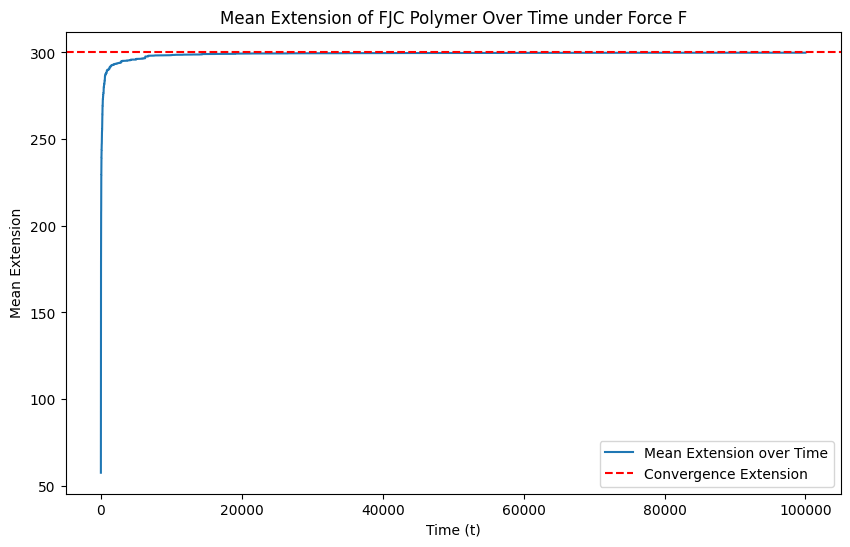

In [5]:
# Now kb is in Hartrees/K, consistent with energy in atomic units and length in angstroms
# Initial positions of monomers
X, Y, Z = x[1,:], y[1,:], z[1,:]

# Constants for the simulation
num_simulations = 10
num_steps = 100000

# Run multiple simulations and calculate mean extensions
mean_extensions = run_multiple_simulations(num_simulations, num_steps, X, Y, Z, F, T, kb_Hartrees_per_K, b)

# Plotting the mean extensions with a red dashed line to indicate convergence
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_steps), mean_extensions, label='Mean Extension over Time')

# Adding a red dashed line to indicate the convergence point
theoretical_extension = 300  
plt.axhline(theoretical_extension, color='red', linestyle='--', label='Convergence Extension')

plt.xlabel('Time (t)')
plt.ylabel('Mean Extension')
plt.title('Mean Extension of FJC Polymer Over Time under Force F')
plt.legend()
plt.show()

In [51]:
F = np.linspace(0.00001, 10, N)  # Force values in eV/Å
extension = []
# Constants for the simulation
num_simulations = 10
num_steps = 10000
for f in F:
    X, Y, Z = x[1,:], y[1,:], z[1,:]
    # Run multiple simulations and calculate mean extensions
    mean_extensions = run_multiple_simulations(num_simulations, num_steps, X, Y, Z, f, T, kb_Hartrees_per_K, b)
    extension.append(mean_extensions[N]/N*b)  

/tmp/ipykernel_19931/3474933727.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_x[j] = new_x[j - 1] + delta_x
/tmp/ipykernel_19931/3474933727.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_y[j] = new_y[j - 1] + delta_y
/tmp/ipykernel_19931/3474933727.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_z[j] = new_z[j - 1] + delta_z


In [36]:
num_data_points = 100
selected_indices = range(0, len(mean_extensions), len(mean_extensions)//num_data_points)
selected_mean_extensions = mean_extensions[selected_indices]
for i in range (100):
    selected_mean_extensions[i] = mean_extensions[100*i]

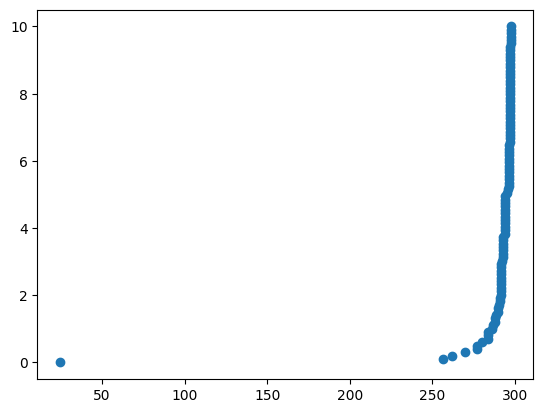

In [37]:
plt.scatter(selected_mean_extensions,F_values)

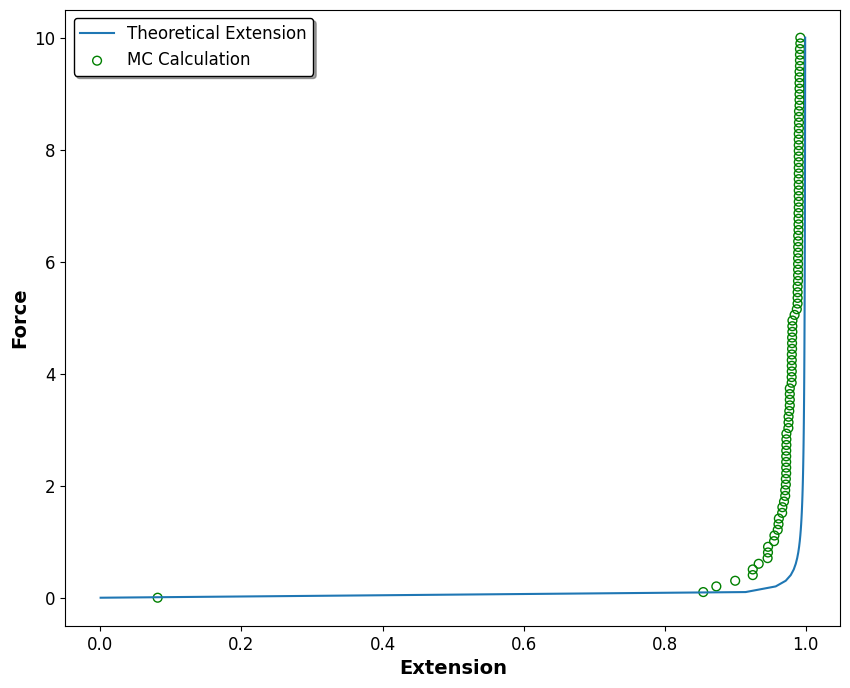

In [42]:
kb = 8.617e-5  #eV/K
# Convert force range to eV/Å (assuming the original force is in Newtons)
F_values = np.linspace(0.00001, 10, N)  # Force values in eV/Å

# Calculate alpha values
alpha = F_values * b / (kb * T)

# Calculate theoretical extension for each force value and normalize it
theoretical_extensions = N * b * (1 / np.tanh(alpha)- 1 / alpha)

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(theoretical_extensions/300, F_values, label='Theoretical Extension')
plt.scatter(selected_mean_extensions/300, F_values, facecolors='none',edgecolors= 'green', s=40, label='MC Calculation')  # Convert back to N for plotting
plt.xlabel('Extension', fontsize=14, fontweight='bold')
plt.ylabel('Force', fontsize=14, fontweight='bold')
plt.legend(fontsize='large', shadow=True, frameon=True, facecolor = 'white', edgecolor = 'black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a background color to the plot area
ax = plt.gca()
# Saving the figure
plt.savefig('force_ex.png', format='png', dpi=300)
plt.show()